# <img src="https://miro.medium.com/max/1200/1*yYFoZKYpp7MT_iAqoE1lRw.png">

# <font color= Red ><u><center>Recommendation System Application in E-commerce</center></u> </font>

## <font color=blue><u>Index</u></font>:
1. [Importing python modules, helper functions and dataset](#import)
2. [Data Exploration](#eda)
     * [Observations from EDA](#obs)
3. [Subsetting data](#sub) 
4. [Splitting data randomly into train and test set](#train)
5. [Building Popularity Recommendation System](#prs)
6. [Building Collaborative Filtering Model](#cf)
7. [Evaluatin Models](#evl)
8. [Getting Top 5 Recommendations](#top5)
9. [Final Result Summary](#summary)

<a id='import'></a>

## 1. Importing python modules, helper functions and dataset

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds

In [2]:
# reading data
data=pd.read_csv("ratings_Electronics.csv",names=['USERID','PRODUCTID','RATINGS','TIMESTAMP'])

In [3]:
# let's view top rows
data.head()

,USERID,PRODUCTID,RATINGS,TIMESTAMP
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# dropping timestamp column
data.drop('TIMESTAMP', axis=1,inplace=True)

In [5]:
data.shape

(7824482, 3)

<a id='eda'></a>

## 2. Data Exploration

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   USERID     object 
 1   PRODUCTID  object 
 2   RATINGS    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [53]:
data.count()

USERID       7824482
PRODUCTID    7824482
RATINGS      7824482
dtype: int64

In [54]:
print(data.isnull().sum())

USERID       0
PRODUCTID    0
RATINGS      0
dtype: int64


In [38]:
# Unique users
data.USERID.nunique()

4201696

In [18]:
# Unique product
data.PRODUCTID.nunique()

476002

In [40]:
data['RATINGS'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: RATINGS, dtype: float64

In [59]:
group_user = data[['USERID','PRODUCTID']].groupby('USERID')
group_prod = data[['USERID','PRODUCTID']].groupby('PRODUCTID')

In [57]:
# Top 5 users with highest frequency 
group_user.count().sort_values(['PRODUCTID'],ascending=False).head()

,PRODUCTID
USERID,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406


In [58]:
# Top 5 users with lowest frequency 
group_user.count().sort_values(['PRODUCTID'],ascending=True).head()

,PRODUCTID
USERID,
A00000262KYZUE4J55XGL,1
A3AAXWDYVQ93SZ,1
A3AAXWHVCN6VOG,1
A3AAXX0N47FFP,1
A3AAXY0TMZS72Y,1


In [62]:
# Top 5 product with highest freqeucy of ratings
group_prod.count().sort_values(['USERID'],ascending=False).head()

,USERID
PRODUCTID,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226


In [63]:
# Top 5 product with lowest freqeucy of ratings
group_prod.count().sort_values(['USERID'],ascending=True).head()

,USERID
PRODUCTID,
0132793040,1
B0058FM05U,1
B0058FM0M8,1
B0058FM320,1
B0058FM5IM,1


### **Since our goal is to recommend products to new customer, we will focus analysis at Product level**

In [7]:
ratings = pd.DataFrame(data.groupby('PRODUCTID')['RATINGS'].mean())

In [8]:
ratings.rename(columns={'RATINGS':'AVG ratings'},inplace=True)

In [9]:
ratings['number_of_ratings'] = data.groupby('PRODUCTID')['RATINGS'].count()

In [27]:
ratings['number_of_ratings'].value_counts().sort_index().head()

1    179738
2     72180
3     40402
4     25899
5     18607
Name: number_of_ratings, dtype: int64

In [38]:
ratings[ratings['number_of_ratings']>50].count()

AVG ratings          25758
number_of_ratings    25758
dtype: int64

In [98]:
ratings.sort_values('number_of_ratings',ascending=False).head()

,AVG ratings,number_of_ratings
PRODUCTID,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226


In [10]:
ratings.sort_values('AVG ratings',ascending=False).head()

,AVG ratings,number_of_ratings
PRODUCTID,,
0132793040,5.0,1
B004SGH244,5.0,1
B004SQBRRM,5.0,1
B004SQC6O0,5.0,1
B004SQE6YI,5.0,1


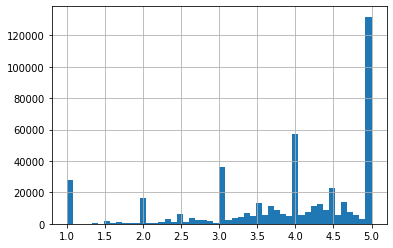

In [100]:
ratings['AVG ratings'].hist(bins=50)

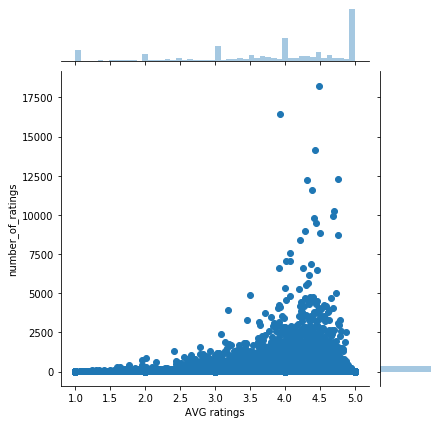

In [103]:
sns.jointplot(x='AVG ratings', y='number_of_ratings', data=ratings)
#plt.title('Average Rating vs Frequency of Ratings')
#plt.show()

In [6]:
ratings_user = pd.DataFrame(data.groupby('USERID')['RATINGS'].mean())

In [7]:
ratings_user.rename(columns={'RATINGS':'AVG ratings'},inplace=True)
ratings_user['number_of_ratings'] = data.groupby('USERID')['RATINGS'].count()

In [8]:
ratings_user['number_of_ratings'].value_counts().sort_index().head()

1    2881832
2     668184
3     265310
4     132306
5      75395
Name: number_of_ratings, dtype: int64

In [9]:
ratings_user[ratings_user['number_of_ratings']>=50].count()

AVG ratings          1540
number_of_ratings    1540
dtype: int64

In [33]:
ratings_user.head()

,AVG ratings,number_of_ratings
USERID,,
A00000262KYZUE4J55XGL,5.0,1
A000063614T1OE0BUSKUT,5.0,2
A00009182QVLSWIGHLS1B,5.0,1
A00009661LC9LQPGKJ24G,5.0,1
A00010809P09NUU6ZP6H,5.0,1


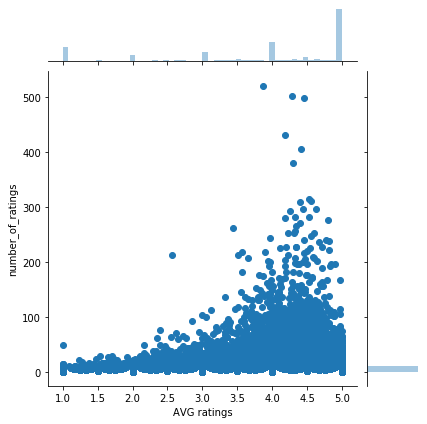

In [16]:
sns.jointplot(x='AVG ratings', y='number_of_ratings', data=ratings_user)
#plt.title('Average Rating vs Frequency of Ratings')
#plt.show()

<a id='obs'></a>

**Observations from EDA:**
    1. Unique number of users are 42,01,696 and unique number of products are 4,76,002
    1. Lowest a user can rate is 1 and highest is 5. 
    2. 50% of the ratings in the dataset is 5 which indicates users who have made ratings only once
    3.Highs and Lows:
        a. 68% of the users have made ratings only once while 1540 users have made ratings for 50  or more times
        b. 38% of the prod had recieved ratings only once while 5% of the prod's have recieved ratings for 50 or more times

<a id='sub'></a>

## 3. Subsetting Data

In [10]:
# filtering data, considering users who have rated 50 or more times
temp_df=ratings_user[ratings_user['number_of_ratings']>=50]

In [11]:
temp_df.reset_index(level=0, inplace=True)

In [12]:
user=list(temp_df.USERID.values)

In [13]:
data = data[pd.Series(list(data.USERID), index=data.index).isin(user)]

In [14]:
data.shape

(125871, 3)

In [57]:
final_ratings_matrix = data.pivot(index = 'USERID', columns ='PRODUCTID', values = 'RATINGS').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


<a id='train'></a>

## 4. Splitting data randomly into train and test set

In [16]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(data, test_size = 0.3, random_state=0)
train_data.head()

,USERID,PRODUCTID,RATINGS
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [22]:
train_data.shape,test_data.shape

((88109, 3), (37762, 3))

<a id='prs'></a>

## 5. Popularity Based Recommender

In [23]:
#creating a pivot view with product with number of number of times it got ratings
train_data_grouped = train_data.groupby('PRODUCTID').agg({'USERID': 'count'}).reset_index()

In [28]:
#renaming the USERID column to score
train_data_grouped.rename(columns = {'USERID': 'score'},inplace=True)

In [29]:
train_data_sort = train_data_grouped.sort_values(['score', 'PRODUCTID'], ascending = [0,1]) 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 

Since popularity based recommendations are not personalised and they will remain same for all the users, we consider top 5 rank product as our top 5 recommendations for the new user

<a id='here'></a>

In [31]:
popularity_based_recommender=train_data_sort.head()
popularity_based_recommender

,PRODUCTID,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


<a id='cf'></a>

## 6. Collaborative Filtering Recommender Model

In [33]:
pivot_df = data.pivot(index = 'USERID', columns ='PRODUCTID', values = 'RATINGS').fillna(0)
pivot_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
USERID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
pivot_df.shape

(1540, 48190)

In [41]:
pivot_df['index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,index
USERID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [42]:
pivot_df.set_index(['index'], inplace=True)
pivot_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
U, sigma, Vt = svds(pivot_df, k = 10)

In [45]:
sigma = np.diag(sigma)

In [46]:
sigma

array([[ 87.43474122,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  88.68897677,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  91.15027972,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  92.15989229,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         95.03789667,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  98.21626326,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [48]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [54]:
userID = 1000
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1000):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.425913
B00829TIEK                  0.0          1.223854
B002R5AM7C                  0.0          1.052991
B004CLYEDC                  0.0          0.945831
B00HFRWWAM                  0.0          0.677177


In [58]:
final_ratings_matrix.mean().head()

PRODUCTID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [59]:
preds_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [60]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
PRODUCTID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


<a id='evl'></a>

## 7. Evalaute Models

In [61]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



<a id='top5'></a>

## 8. Getting Top 5 Recommendations

In [69]:
userID = 1500
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1500):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          1.078326
B007WTAJTO                  0.0          0.933721
B002V88HFE                  0.0          0.635227
B00829TIEK                  0.0          0.590629
B002SZEOLG                  0.0          0.519811


<a id='summary'></a>

## 9. Summary
1. Since Popularity Based Recommender is just a rank based approach with no model function used as such, we can't evualate the performance of the Popularity based recommender
2. Popularity based recommendations would remain same for all the users no matter how theirs habits are or what they prefer. [This](#here) recommendations will remain same for all the users as long as the data remains the same
3. On the other recommendations through Collaborative filtering model are different and personalised
4. Based on users habit, we can recommend top 5 products with an RMSE of <u > 0.0033 </u>
